In [1]:
try:
    from scikeras.wrappers import KerasRegressor                     
except ImportError:
    !pip install scikeras
    from scikeras.wrappers import KerasRegressor
    
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import sklearn
from sklearn.pipeline import Pipeline # for setting up a pre-processing / tuning pipeline.
from sklearn.preprocessing import RobustScaler # Here, we are going to normalize inputs (the ML Pipeline framework from sklearn can implement this.)

# So, we are going back to the Boston Housing data here.
from tensorflow.keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = (boston_housing.load_data())

  Attempting uninstall: importlib-metadata
    Found existing installation: importlib-metadata 4.10.1
    Uninstalling importlib-metadata-4.10.1:
      Successfully uninstalled importlib-metadata-4.10.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
markdown 3.3.6 requires importlib-metadata>=4.4; python_version < "3.10", but you have importlib-metadata 3.10.1 which is incompatible.
65536/57026 [==================================] - 0s 0us/step


#*Grid Search CV With Keras Model*

In [7]:
# Make sure you set your custom parameters for training as arguments in your model creation function.
def create_model(loss="mean_squared_error",optimizer="sgd",activation="relu",units=100,numLayers=2, batch_size=10):
    
    # I beleve that you need to explicitly declare an input layer for the scikeras wrapper to work... 
    model = keras.Sequential([
        layers.Input(train_data.shape[1]), 
        layers.Dense(units, activation="relu")             
    ])

    if numLayers == 2:
        model.add(layers.Dense(units, activation="relu"))

    model.add(layers.Dense(1, activation=activation))

    model.compile(loss=loss,optimizer=optimizer, metrics=['mse'])
    return model

# You also need to specify the 'custom' parameters here that you want to add, for them to show up as a trainable parameter in GridSearchCV.
regf = KerasRegressor(model=create_model, loss="mean_squared_error", optimizer="adam", activation="relu", units=100, numLayers=2, batch_size=10, verbose=0)

# Note you can also do a grid search over an sklearn pipeline, so you can search over diferent types of data pre-processing approaches too!
ml_pipeline = Pipeline([("Normalize_with_centering", RobustScaler()), ("Model", regf)])

# Here are the configurable parameters we can now search over for either object. 
#print(regf.get_params().keys())
print(ml_pipeline.get_params().keys())

dict_keys(['memory', 'steps', 'verbose', 'Normalize_with_centering', 'Model', 'Normalize_with_centering__copy', 'Normalize_with_centering__quantile_range', 'Normalize_with_centering__unit_variance', 'Normalize_with_centering__with_centering', 'Normalize_with_centering__with_scaling', 'Model__model', 'Model__build_fn', 'Model__warm_start', 'Model__random_state', 'Model__optimizer', 'Model__loss', 'Model__metrics', 'Model__batch_size', 'Model__validation_batch_size', 'Model__verbose', 'Model__callbacks', 'Model__validation_split', 'Model__shuffle', 'Model__run_eagerly', 'Model__epochs', 'Model__activation', 'Model__units', 'Model__numLayers'])


And this is how I would invoke my grid search... 

In [ ]:
from sklearn.model_selection import GridSearchCV
import numpy as np

# Because we are creating the models but are not compiling them yet (we will let the grid fit compile the models on the fly),
# this will produce a bunch of warnings. I'm just suppressing the warnings. 
#import logging, os
#logging.disable(logging.WARNING)
#os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

params = {
    "numLayers": [1,2],
    "units": [100,125],
    #"activation": ['relu','selu',None],
    #"batch_size": [25,50],
    #"epochs": [10,20,30]
}

params_pipe = {
    "Model__numLayers": [1,2],
    "Model__units": [100,500],
    "Model__activation": ['relu','selu',None],
    "Model__batch_size": [25,50],
    "Model__epochs":[10,20,30]
}

#grid = GridSearchCV(regf, params, scoring='neg_mean_absolute_error',verbose=11)#,cv=10)
grid = GridSearchCV(ml_pipeline, params_pipe, scoring='neg_mean_absolute_error',verbose=11)#,cv=10)

grid.fit(train_data, train_targets)

Fitting 5 folds for each of 72 candidates, totalling 360 fits
[CV 1/5; 1/72] START Model__activation=relu, Model__batch_size=25, Model__epochs=10, Model__numLayers=1, Model__units=100
[CV 1/5; 1/72] END Model__activation=relu, Model__batch_size=25, Model__epochs=10, Model__numLayers=1, Model__units=100;, score=-2.886 total time=   0.9s
[CV 2/5; 1/72] START Model__activation=relu, Model__batch_size=25, Model__epochs=10, Model__numLayers=1, Model__units=100
[CV 2/5; 1/72] END Model__activation=relu, Model__batch_size=25, Model__epochs=10, Model__numLayers=1, Model__units=100;, score=-23.710 total time=   1.2s
[CV 3/5; 1/72] START Model__activation=relu, Model__batch_size=25, Model__epochs=10, Model__numLayers=1, Model__units=100
[CV 3/5; 1/72] END Model__activation=relu, Model__batch_size=25, Model__epochs=10, Model__numLayers=1, Model__units=100;, score=-3.103 total time=   1.1s
[CV 4/5; 1/72] START Model__activation=relu, Model__batch_size=25, Model__epochs=10, Model__numLayers=1, Mode

I can then extract the parameters that yielded the top performance... 

In [5]:
print(f"Best Score  : {grid.best_score_}")
print(f"Best Params : {grid.best_params_}")

Best Score  : -22.398225308641976
Best Params : {'numLayers': 1, 'units': 100}


Finally, a little function that looks at pairs of parameter values, and the associated model performance, holding all other parameters to their ideal values. 

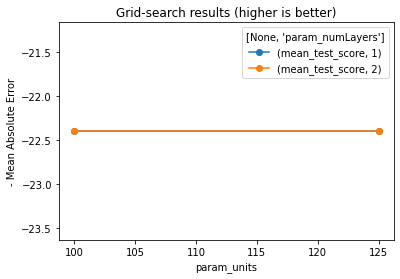

In [6]:
import matplotlib.pyplot as plt
import pandas as pd

def plot_results(index='units', columns='activation'):
    index = 'param_' + index
    columns = 'param_' + columns

    # prepare the results into a pandas.DataFrame
    df = pd.DataFrame(grid.cv_results_)

    # Remove the other by selecting their best values (from gscv.best_params_)
    other = [c for c in df.columns if c[:6] == 'param_']
    other.remove(index)
    other.remove(columns)

    # Set all other parameters to their "top" values.
    for col in other:
        df = df[df[col] == grid.best_params_[col[6:]]]

    # Create pivot tables for easy plotting
    table_mean = df.pivot_table(index=index, columns=columns,
                                values=['mean_test_score'])
    
    # plot the pivot tables
    plt.figure()
    ax = plt.gca()
    for col_mean in table_mean.columns:
        table_mean[col_mean].plot(marker='o',label=col_mean)
    plt.title('Grid-search results (higher is better)')
    plt.ylabel('- Mean Absolute Error')
    plt.legend(title=table_mean.columns.names)
    plt.show()

plot_results(index='units', columns='numLayers')